In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import sys
sys.path.append("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI")



In [2]:
sys.path.append("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/utils")

from utils.sequence import uniprot2sequence, encode_sequences
from utils.chem import *
from utils.parallel import *
from utils.sequence import encode_sequences
from utils.chem import get_mols, get_fp  

/home/resperanca/miniconda3/envs/rdkit_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [3]:
import pickle
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score
from rdkit import Chem
from xgboost import XGBClassifier

sys.path.append("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model")

from base_model import BaseModel
from preprocessor import Preprocessor
from barlow_twins import BarlowTwins



# 1 STEP- COMPARING MY RESULTS WITH THOSE IN THE LITERATURE

#  BindingDB

### Split and preprocess

In [ ]:
import pandas as pd

base_path = "/home/resperanca/Tuberculosis_Tese/BarlowDTI/dataset/extracted/BindingDB/"

train_df = pd.read_csv(base_path + "train.csv")
val_df   = pd.read_csv(base_path + "val.csv")
test_df  = pd.read_csv(base_path + "test.csv")

train_df["split"] = "train"
val_df["split"] = "val"
test_df["split"] = "test"

full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print(full_df.head())

In [2]:
full_df.rename(columns={"smile": "smiles"}, inplace=True)

In [8]:
full_df.rename(columns={"SMILES": "smiles","Sequence": "sequence","Label": "label" }, inplace=True)

In [ ]:
unique_seqs = full_df['sequence'].unique()
seq_lengths = [len(seq) for seq in unique_seqs]
sorted_lengths = sorted(seq_lengths, reverse=True)
print(sorted_lengths)
print("medium size:", np.mean(seq_lengths))
print("min size:", np.min(seq_lengths))
print("max size:", np.max(seq_lengths))

In [19]:
print("Percentil 95:", np.percentile(seq_lengths, 95))

Percentil 95: 1341.3999999999999


In [20]:
max_len = 1341

full_df['sequence'] = full_df['sequence'].apply(
    lambda seq: seq[:max_len] if len(seq) > max_len else seq
)

### Model train

### Load and visualize the training history 

In [21]:
test_dataset_path = "/home/resperanca/Tuberculosis_Tese/Binding_BARLOW.csv"
full_df.to_csv(test_dataset_path, index=False)

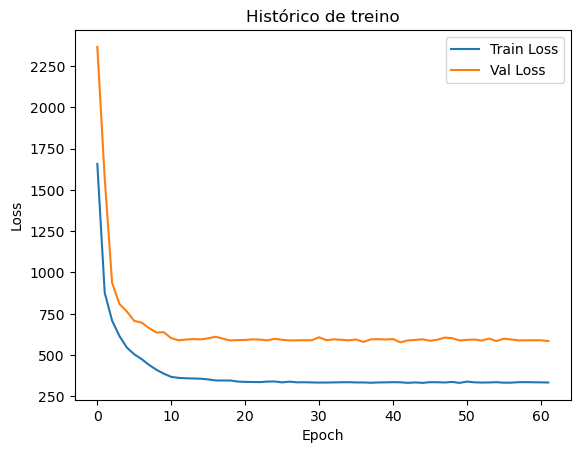

In [ ]:
import pickle
import os
import matplotlib.pyplot as plt


path = "/home/resperanca/Tuberculosis_Tese/BarlowDTI/model/stash/bin4" 


with open(os.path.join(path, "history.json"), "rb") as f:
    history = pickle.load(f)

plt.plot(history["train_loss"], label="Train Loss")
if "validation_loss" in history:
    plt.plot(history["validation_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("history train")
plt.show()

#### The output obtained in this case shows that the training loss decreases sharply during the first epochs and then stabilizes at a relatively low value, which indicates that the model was able to learn the patterns in the training set effectively. The validation loss, on the other hand, decreases initially but plateaus at a significantly higher value compared to the training loss. This gap between the two curves suggests that the model is overfitting: it is fitting the training data well but does not generalize equally well to new data. This observation highlights the need for regularization strategies, hyperparameter tuning, or a larger and more diverse training dataset to improve generalization performance.

### Next code demonstrates how pretrained embeddings from a Barlow Twins model can be used to build a downstream classifier for drug–target interactions. The process avoids retraining the neural network and instead leverages the representations it has already learned.

### Preprocessor

In [ ]:

preprocessor = Preprocessor(
    path="/home/resperanca/Tuberculosis_Tese/Data/DTI_Data_2_step/Papyrus_Barlow.csv",  
    radius=2,
    n_bits=1024,
    aa_embedding="prot_t5",
    num_workers=4
)

import pickle
with open("preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

### Classifier

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BarlowTwins()
model.load_model("/home/resperanca/Tuberculosis_Tese/BarlowDTI/model/stash/bin4")  

fps = preprocessor.fp
aas = preprocessor.aa
splits = preprocessor.split
labels = preprocessor.label


train_idx = [i for i, s in enumerate(splits) if s == "train"]
fp_train = np.stack([fps[i] for i in train_idx])
aa_train = np.stack([aas[i] for i in train_idx])
y_train = [labels[i] for i in train_idx]

test_idx = [i for i, s in enumerate(splits) if s == "test"]
fp_test = np.stack([fps[i] for i in test_idx])
aa_test = np.stack([aas[i] for i in test_idx])
y_test = [labels[i] for i in test_idx]

def zero_shot_batched(model, mol_array, aa_array, batch_size=256, device="cuda"):
    embeddings = []
    n_samples = mol_array.shape[0]

    for i in range(0, n_samples, batch_size):
        mol_batch = mol_array[i:i+batch_size]
        aa_batch = aa_array[i:i+batch_size]

        with torch.no_grad():
            emb = model.zero_shot(mol_batch, aa_batch, device=device)
            embeddings.append(emb)

    return np.vstack(embeddings)

X_train = zero_shot_batched(model, fp_train, aa_train, device=device)
X_test = zero_shot_batched(model, fp_test, aa_test, device=device)

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

clf = XGBClassifier(n_estimators=500, max_depth=5, random_state=42)
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_test)[:, 1]
roc = roc_auc_score(y_test, preds)
pr = average_precision_score(y_test, preds)

print(f"✅ ROC-AUC: {roc:.4f}")
print(f"✅ PR-AUC:  {pr:.4f}")


### Metrics

📊 Accuracy:  0.8549
🎯 Precision: 0.4967
🔁 Recall:    0.8672
🧮 F1 Score:  0.6316


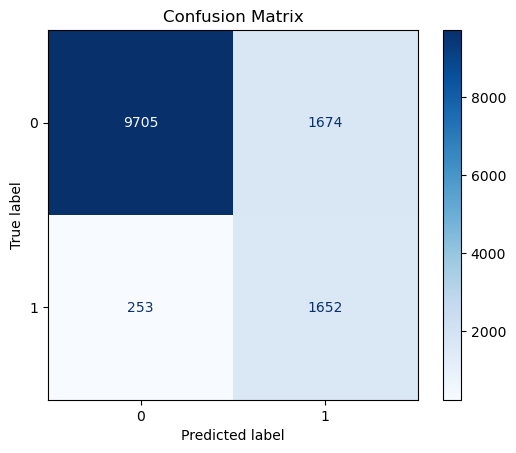

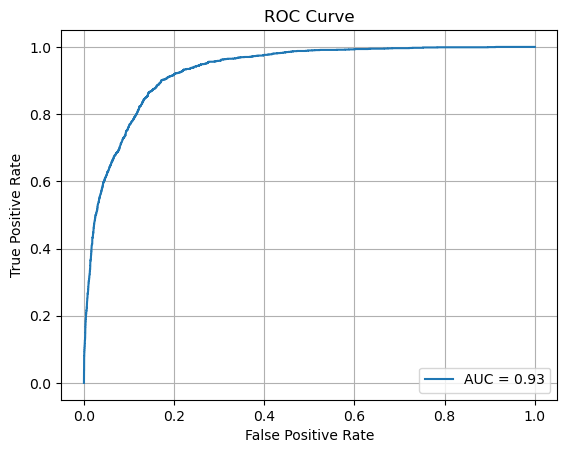

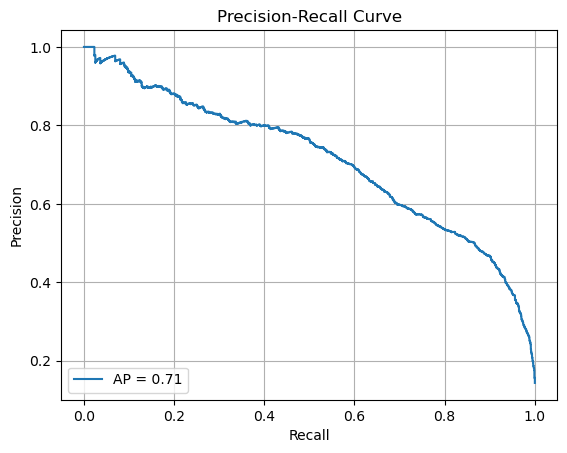

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

y_pred_binary = (preds >= 0.5).astype(int)

f1 = f1_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
acc = accuracy_score(y_test, y_pred_binary)
cm = confusion_matrix(y_test, y_pred_binary)

print(f"📊 Accuracy:  {acc:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"🔁 Recall:    {recall:.4f}")
print(f"🧮 F1 Score:  {f1:.4f}")

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, preds)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc)
roc_display.plot()
plt.title("ROC Curve")
plt.grid(True)
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, preds)
pr_display = PrecisionRecallDisplay(precision=prec, recall=rec, average_precision=pr)
pr_display.plot()
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


### As we can see in this metrics, the results are pretty close to the literature results

# 2 Step- Comparison between a base model with ESm + Morgan Fingerprints and the Barlow model

### Base with simple sequence encoding Papyrus

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
import esm


df = pd.read_csv("/home/resperanca/Tuberculosis_Tese/Data/DTI_Data_2_step/Papyrus_Barlow.csv")
df = df.dropna(subset=["smiles", "sequence", "label"])
df["label"] = df["label"].astype(int)


def smiles_to_ecfp(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    return np.zeros(nBits)

df["fp"] = df["smiles"].apply(smiles_to_ecfp)

model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval() 

sequences = [("protein1", "MESYHKPDQQLKDL..."), ...]  
batch_labels, batch_strs, batch_tokens = batch_converter(sequences)

with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=False)


token_representations = results["representations"][33]

protein_embeddings = []
for i, (_, seq) in enumerate(sequences):
    emb = token_representations[i, 1:len(seq)+1].mean(0) 
    protein_embeddings.append(emb.numpy())

df["seq_encoded"] = df["sequence"].apply(simple_seq_encode)

X_baseline = np.stack(df["fp"].values)
X_seq = np.stack(df["seq_encoded"].values)
X_raw = np.concatenate([X_baseline, X_seq], axis=1)
y = df["label"].values

train_idx = df["split"] == "train"
val_idx = df["split"] == "val"
test_idx = df["split"] == "test"

X_train_raw = X_raw[train_idx]
X_val_raw = X_raw[val_idx]
X_test_raw = X_raw[test_idx]

y_train = y[train_idx]
y_val = y[val_idx]
y_test = y[test_idx]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)
X_test_scaled = scaler.transform(X_test_raw)

def evaluate(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
    else:
        probs = model.decision_function(X_test)
     
        probs = (probs - probs.min()) / (probs.max() - probs.min())
    preds = (probs >= 0.5).astype(int)
    print(f"\n📌 Resultados para {name}")
    print(f"AUC:       {roc_auc_score(y_test, probs):.4f}")
    print(f"F1 Score:  {f1_score(y_test, preds):.4f}")
    print(f"Precision: {precision_score(y_test, preds):.4f}")
    print(f"Recall:    {recall_score(y_test, preds):.4f}")
    print(f"Accuracy:  {accuracy_score(y_test, preds):.4f}")
    print(f"MCC:       {matthews_corrcoef(y_test, preds):.4f}")

evaluate(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    X_train_scaled, X_test_scaled, y_train, y_test, "Baseline XGBoost"
)

evaluate(
    SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3),
    X_train_scaled, X_test_scaled, y_train, y_test, "Baseline Linear SVM (SGD)"
)

X_train = zero_shot_batched(model, fp_train, aa_train, device=device)
X_test = zero_shot_batched(model, fp_test, aa_test, device=device)




/home/resperanca/miniconda3/envs/rdkit_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:00:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1727231492252/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📌 Resultados para Baseline XGBoost
AUC:       0.8660
F1 Score:  0.8012
Precision: 0.7808
Recall:    0.8228
Accuracy:  0.7843
MCC:       0.5668

📌 Resultados para Baseline Linear SVM (SGD)
AUC:       0.7527
F1 Score:  0.6943
Precision: 0.5318
Recall:    0.9997
Accuracy:  0.5349
MCC:       0.0840


### Base with simple sequence encoding Papyrus + TB

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

df = pd.read_csv("/home/resperanca/Tuberculosis_Tese/Data/DTI_Data_2_step/Papyrus_TB_Barlow.csv")
df = df.dropna(subset=["smiles", "sequence", "label"])
df["label"] = df["label"].astype(int)


def smiles_to_ecfp(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    return np.zeros(nBits)

df["fp"] = df["smiles"].apply(smiles_to_ecfp)


def simple_seq_encode(seq, max_len=1500):
    vocab = {aa: idx+1 for idx, aa in enumerate("ACDEFGHIKLMNPQRSTVWY")}
    vec = [vocab.get(aa, 0) for aa in seq.upper()]
    padded = vec[:max_len] + [0]*(max_len - len(vec)) if len(vec) < max_len else vec[:max_len]
    return np.array(padded)

df["seq_encoded"] = df["sequence"].apply(simple_seq_encode)


X_baseline = np.stack(df["fp"].values)
X_seq = np.stack(df["seq_encoded"].values)
X_raw = np.concatenate([X_baseline, X_seq], axis=1)
y = df["label"].values

train_idx = df["split"] == "train"
val_idx = df["split"] == "val"
test_idx = df["split"] == "test"

X_train_raw = X_raw[train_idx]
X_val_raw = X_raw[val_idx]
X_test_raw = X_raw[test_idx]

y_train = y[train_idx]
y_val = y[val_idx]
y_test = y[test_idx]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)
X_test_scaled = scaler.transform(X_test_raw)


def evaluate(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
    else:
        probs = model.decision_function(X_test)
        
        probs = (probs - probs.min()) / (probs.max() - probs.min())
    preds = (probs >= 0.5).astype(int)
    print(f"\n📌 Resultados para {name}")
    print(f"AUC:       {roc_auc_score(y_test, probs):.4f}")
    print(f"F1 Score:  {f1_score(y_test, preds):.4f}")
    print(f"Precision: {precision_score(y_test, preds):.4f}")
    print(f"Recall:    {recall_score(y_test, preds):.4f}")
    print(f"Accuracy:  {accuracy_score(y_test, preds):.4f}")
    print(f"MCC:       {matthews_corrcoef(y_test, preds):.4f}")

evaluate(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    X_train_scaled, X_test_scaled, y_train, y_test, "Baseline XGBoost"
)

evaluate(
    SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3),
    X_train_scaled, X_test_scaled, y_train, y_test, "Baseline Linear SVM (SGD)"
)

X_train = zero_shot_batched(model, fp_train, aa_train, device=device)
X_test = zero_shot_batched(model, fp_test, aa_test, device=device)


/home/resperanca/miniconda3/envs/rdkit_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:50:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1727231492252/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📌 Resultados para Baseline XGBoost
AUC:       0.8659
F1 Score:  0.7991
Precision: 0.7809
Recall:    0.8181
Accuracy:  0.7853
MCC:       0.5695

📌 Resultados para Baseline Linear SVM (SGD)
AUC:       0.7585
F1 Score:  0.6889
Precision: 0.5256
Recall:    0.9996
Accuracy:  0.5289
MCC:       0.0852


### Base with simple sequence encoding TB


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem


df = pd.read_csv("/home/resperanca/Tuberculosis_Tese/Data/Tuberculosis_Data/tb_fina_BARLOW.csv")
df = df.dropna(subset=["smiles", "sequence", "label"])
df["label"] = df["label"].astype(int)

def smiles_to_ecfp(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    return np.zeros(nBits)

df["fp"] = df["smiles"].apply(smiles_to_ecfp)

def simple_seq_encode(seq, max_len=1500):
    vocab = {aa: idx+1 for idx, aa in enumerate("ACDEFGHIKLMNPQRSTVWY")}
    vec = [vocab.get(aa, 0) for aa in seq.upper()]
    padded = vec[:max_len] + [0]*(max_len - len(vec)) if len(vec) < max_len else vec[:max_len]
    return np.array(padded)

df["seq_encoded"] = df["sequence"].apply(simple_seq_encode)

X_baseline = np.stack(df["fp"].values)
X_seq = np.stack(df["seq_encoded"].values)
X_raw = np.concatenate([X_baseline, X_seq], axis=1)
y = df["label"].values

train_idx = df["split"] == "train"
val_idx = df["split"] == "val"
test_idx = df["split"] == "test"

X_train_raw = X_raw[train_idx]
X_val_raw = X_raw[val_idx]
X_test_raw = X_raw[test_idx]

y_train = y[train_idx]
y_val = y[val_idx]
y_test = y[test_idx]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)
X_test_scaled = scaler.transform(X_test_raw)

def evaluate(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
    else:
        probs = model.decision_function(X_test)
        
        probs = (probs - probs.min()) / (probs.max() - probs.min())
    preds = (probs >= 0.5).astype(int)
    print(f"\n📌 Resultados para {name}")
    print(f"AUC:       {roc_auc_score(y_test, probs):.4f}")
    print(f"F1 Score:  {f1_score(y_test, preds):.4f}")
    print(f"Precision: {precision_score(y_test, preds):.4f}")
    print(f"Recall:    {recall_score(y_test, preds):.4f}")
    print(f"Accuracy:  {accuracy_score(y_test, preds):.4f}")
    print(f"MCC:       {matthews_corrcoef(y_test, preds):.4f}")

evaluate(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    X_train_scaled, X_test_scaled, y_train, y_test, "Baseline XGBoost"
)

evaluate(
    SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3),
    X_train_scaled, X_test_scaled, y_train, y_test, "Baseline Linear SVM (SGD)"
)




## Base whit ESM

In [ ]:
import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score,
    recall_score, accuracy_score, matthews_corrcoef
)
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import esm
from tqdm import tqdm


df = pd.read_csv("/home/resperanca/Tuberculosis_Tese/Data/Tuberculosis_Data/tb_fina_BARLOW.csv")
df = df.dropna(subset=["smiles", "sequence", "label"])
df["label"] = df["label"].astype(int)

def smiles_to_ecfp(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    return np.zeros(nBits)

df["fp"] = df["smiles"].apply(smiles_to_ecfp)

import esm
import torch
from tqdm import tqdm


model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = model.half().to(device)
model.eval()


sequences = [("protein"+str(i), seq) for i, seq in enumerate(df["sequence"].tolist())]

protein_embeddings = []
batch_size = 16 

for i in tqdm(range(0, len(sequences), batch_size)):
    batch_seqs = sequences[i:i+batch_size]
    batch_labels, batch_strs, batch_tokens = batch_converter(batch_seqs)

    with torch.no_grad():
        results = model(
            batch_tokens.to(device), 
            repr_layers=[6],  
            return_contacts=False
        )

    token_representations = results["representations"][6]

    for j, (_, seq) in enumerate(batch_seqs):
        emb = token_representations[j, 1:len(seq)+1].mean(0)
        protein_embeddings.append(emb.cpu().numpy())


df["esm_emb"] = protein_embeddings


X_ecfp = np.stack(df["fp"].values)
X_esm = np.stack(df["esm_emb"].values)
X_raw = np.concatenate([X_ecfp, X_esm], axis=1)
y = df["label"].values

train_idx = df["split"] == "train"
test_idx = df["split"] == "test"

X_train_raw = X_raw[train_idx]
X_test_raw = X_raw[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

def evaluate(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
    else:
        probs = model.decision_function(X_test)
        probs = (probs - probs.min()) / (probs.max() - probs.min())
    preds = (probs >= 0.5).astype(int)
    return {
        "Modelo": name,
        "AUC": roc_auc_score(y_test, probs),
        "F1 Score": f1_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "Accuracy": accuracy_score(y_test, preds),
        "MCC": matthews_corrcoef(y_test, preds)
    }

results = []
results_tb = []

results_tb.append(evaluate(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    X_train_scaled, X_test_scaled, y_train, y_test, "ESM + ECFP XGBoost"
))

results_tb.append(evaluate(
    SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3),
    X_train_scaled, X_test_scaled, y_train, y_test, "ESM + ECFP Linear SVM"
))



In [5]:
#Papyrus + TB

results

[{'Modelo': 'ESM + ECFP XGBoost',
  'AUC': 0.8665224188220213,
  'F1 Score': 0.8000093524591122,
  'Precision': 0.7780607604147717,
  'Recall': 0.823232201717874,
  'Accuracy': 0.7851904869534644,
  'MCC': 0.5694637715862118},
 {'Modelo': 'ESM + ECFP Linear SVM',
  'AUC': 0.7399070464729247,
  'F1 Score': 0.7250387756246146,
  'Precision': 0.5926859447321388,
  'Recall': 0.9334985443784135,
  'Accuracy': 0.6304779125543083,
  'MCC': 0.30453412019922693}]

In [ ]:
# TB

results_tb

[{'Modelo': 'ESM + ECFP XGBoost',
  'AUC': 0.8718608446576073,
  'F1 Score': 0.4409448818897638,
  'Precision': 0.6086956521739131,
  'Recall': 0.345679012345679,
  'Accuracy': 0.8885400313971743,
  'MCC': 0.40325007073593205},
 {'Modelo': 'ESM + ECFP Linear SVM',
  'AUC': 0.7977506883382183,
  'F1 Score': 0.24508320726172467,
  'Precision': 0.1396551724137931,
  'Recall': 1.0,
  'Accuracy': 0.21664050235478807,
  'MCC': 0.1196543645509444}]

# Step 3- Barlow Twins analisys

## Papyrus

In [ ]:
# import pandas as pd


# df = pd.read_csv('/home/resperanca/Tuberculosis_Tese/Data/Tuberculosis_Data/tb_fina_BARLOW.csv')  
# df_filtrado = df[df['split'].isin(['test'])]
# df_filtrado.to_csv('/home/resperanca/Tuberculosis_Tese/Data/Tuberculosis_Data/tb_test_BARLOW.csv', index=False)




In [51]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, confusion_matrix, average_precision_score
)
import seaborn as sns
import matplotlib.pyplot as plt

test_path = "/home/resperanca/Tuberculosis_Tese/Data/DTI_Data_2_step/metricstb.csv"  
barlow_model_path = "/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/stash/Papyrus_tb"  

bt_model = BarlowTwins()
bt_model.load_model(barlow_model_path)


test_df = pd.read_csv(test_path)

# ECFPs e embeddings 
test_mols = [Chem.MolFromSmiles(smi) for smi in test_df["smiles"]]
test_ecfp = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in test_mols]
test_ecfp = np.array(test_ecfp)

test_emb = encode_sequences(test_df["sequence"].tolist(), encoder="prost_t5")
test_emb = np.array([np.array(x) for x in test_emb])

# Conct embeddings
test_vectors = bt_model.zero_shot(test_ecfp, test_emb)
true_labels = test_df["label"].values




[BT]: Model constructed successfully
[BT]: Optimizer constructed successfully
[BT]: Current parameter config:
{'act_function': <class 'torch.nn.modules.activation.ReLU'>, 'loss_weight': 0.005, 'batch_size': 512, 'learning_rate': 0.0001, 'betas': (0.9, 0.999), 'step_size': 10, 'gamma': 0.1, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'momentum': 0.9, 'enc_n_neurons': 512, 'enc_n_layers': 2, 'proj_n_neurons': 2048, 'proj_n_layers': 2, 'embedding_dim': 512, 'weight_decay': 0.001, 'verbose': True, 'radius': 'Not defined yet', 'n_bits': 1024, 'aa_emb_size': 1024}


/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/barlow_twins.py:491: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map

[BT]: Model constructed successfully
[BT]: Optimizer constructed successfully
[BT]: Model loaded from /home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/stash/Papyrus_tb
[BT]: Loaded parameters:
{'act_function': <class 'torch.nn.modules.activation.ReLU'>, 'loss_weight': 0.001, 'batch_size': 512, 'learning_rate': 0.0001, 'betas': (0.9, 0.999), 'step_size': 10, 'gamma': 0.1, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'momentum': 0.9, 'enc_n_neurons': 4096, 'enc_n_layers': 3, 'proj_n_neurons': 4096, 'proj_n_layers': 1, 'embedding_dim': 256, 'weight_decay': 0.0015, 'verbose': True, 'radius': 2, 'n_bits': 1024, 'aa_emb_size': 1024}


Encoding sequences: 100%|██████████| 1278/1278 [00:08<00:00, 145.57it/s]


## XGBOOST

In [ ]:
xgb_model = XGBClassifier()
xgb_model.load_model("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/xxl_stash/Papyrus_barlowdti_xxl_model.json")

# === Previsões e Avaliação para GBM ===
print("\n===== Avaliação - XGBoost =====")
gbm_preds = xgb_model.predict_proba(test_vectors)[:, 1]
gbm_binary = (gbm_preds >= 0.5).astype(int)

roc = roc_auc_score(true_labels, gbm_preds)
acc = accuracy_score(true_labels, gbm_binary)
prec = precision_score(true_labels, gbm_binary)
rec = recall_score(true_labels, gbm_binary)
f1 = f1_score(true_labels, gbm_binary)
mcc = matthews_corrcoef(true_labels, gbm_binary)
pr_auc = average_precision_score(true_labels, gbm_preds)
cm = confusion_matrix(true_labels, gbm_binary)

print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ACCURACY: {acc:.4f}")
print(f"PRECISION: {prec:.4f}")
print(f"RECALL: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")



===== Avaliação - XGBoost =====
ROC-AUC: 0.8709
PR-AUC: 0.8771
ACCURACY: 0.7875
PRECISION: 0.7941
RECALL: 0.8071
F1-Score: 0.8005
MCC: 0.5733


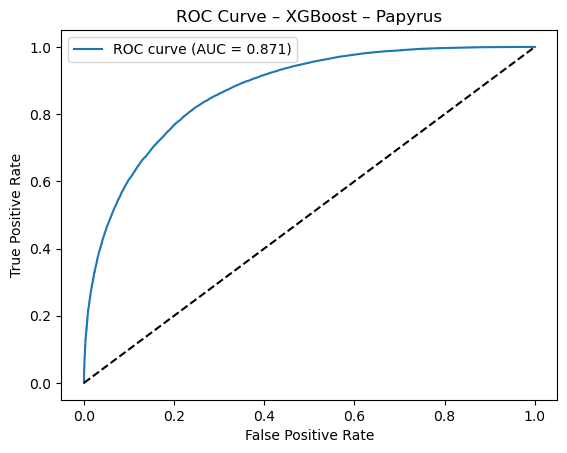

In [17]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_labels, gbm_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost – Papyrus")
plt.legend()
plt.show()

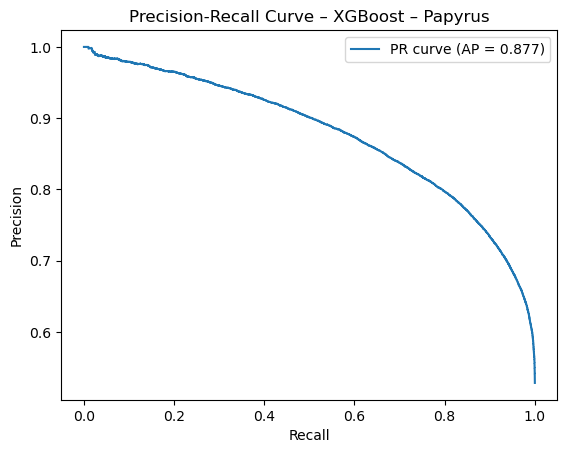

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(true_labels, gbm_preds)
ap = average_precision_score(true_labels, gbm_preds)

plt.figure()
plt.plot(rec, prec, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – XGBoost – Papyrus")
plt.legend()
plt.show()

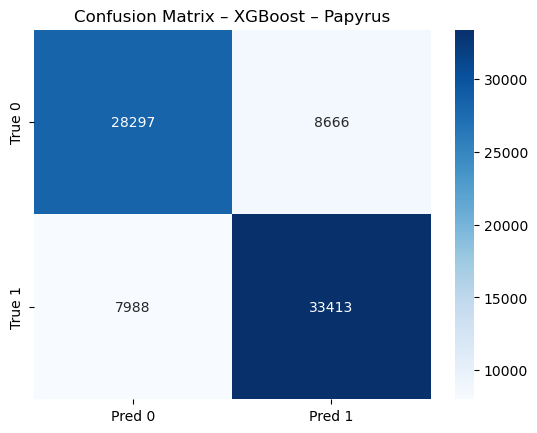

In [19]:
cm = confusion_matrix(true_labels, gbm_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix – XGBoost – Papyrus")
plt.show()

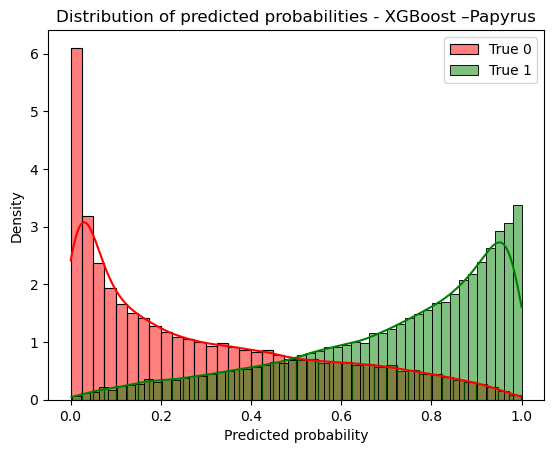

In [20]:
plt.figure()
sns.histplot(gbm_preds[true_labels==0], color="red", label="True 0", kde=True, stat="density")
sns.histplot(gbm_preds[true_labels==1], color="green", label="True 1", kde=True, stat="density")
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.title("Distribution of predicted probabilities - XGBoost –Papyrus")
plt.legend()
plt.show()

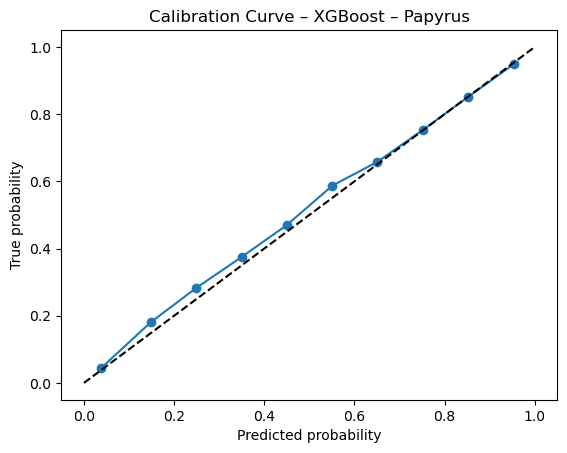

In [21]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(true_labels, gbm_preds, n_bins=10)

plt.figure()
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Calibration Curve – XGBoost – Papyrus")
plt.show()

## SVM

ROC-AUC: 0.7239
PR-AUC: 0.7192
ACCURACY: 0.6702
PRECISION: 0.6729
RECALL: 0.7313
F1-Score: 0.7009
MCC: 0.3363


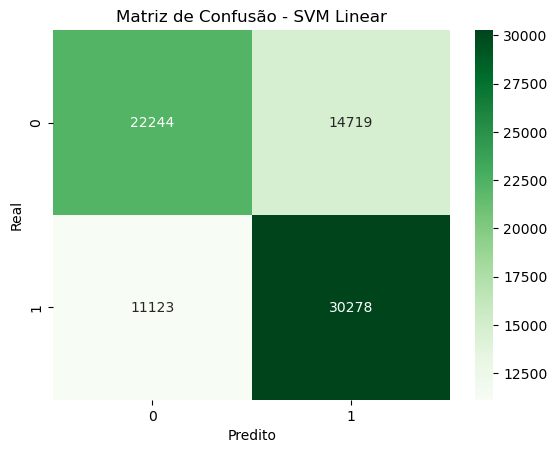

In [22]:
import joblib
from sklearn.metrics import *

# Carregar modelo e scaler
svm = joblib.load("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/xxl_stash/Papyrus_barlowdti_xxl_model_svm.pkl") 
scaler = joblib.load("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/xxl_stash/Papyrus_barlowdti_xxl_svm_scaler.pkl") #

test_bt_scaled = scaler.transform(test_vectors)

# Como não há predict_proba com hinge, usas decision_function
decision_scores = svm.decision_function(test_bt_scaled)
binary_preds = (decision_scores >= 0).astype(int)

roc = roc_auc_score(true_labels, decision_scores)
acc = accuracy_score(true_labels, binary_preds)
prec = precision_score(true_labels, binary_preds)
rec = recall_score(true_labels, binary_preds)
f1 = f1_score(true_labels, binary_preds)
mcc = matthews_corrcoef(true_labels, binary_preds)
pr_auc = average_precision_score(true_labels, decision_scores)
cm = confusion_matrix(true_labels, binary_preds)

print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ACCURACY: {acc:.4f}")
print(f"PRECISION: {prec:.4f}")
print(f"RECALL: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusão - SVM Linear")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


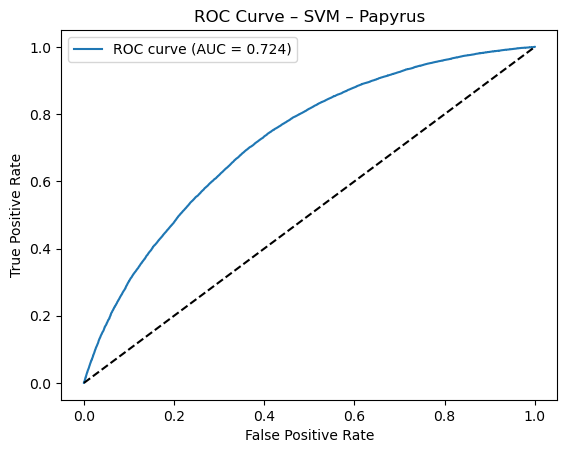

In [23]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_labels, decision_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – SVM – Papyrus")
plt.legend()
plt.show()

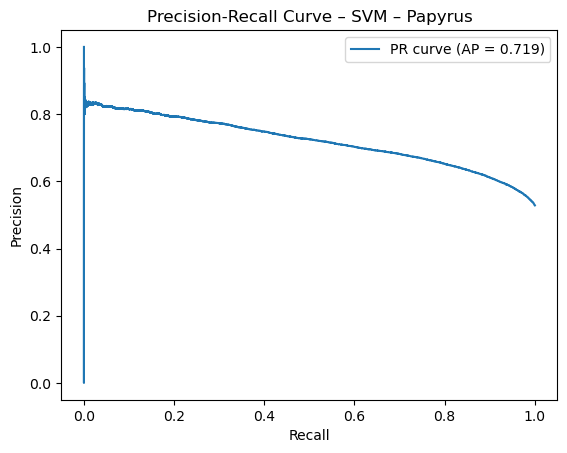

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(true_labels, decision_scores)
ap = average_precision_score(true_labels, decision_scores)

plt.figure()
plt.plot(rec, prec, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – SVM – Papyrus")
plt.legend()
plt.show()

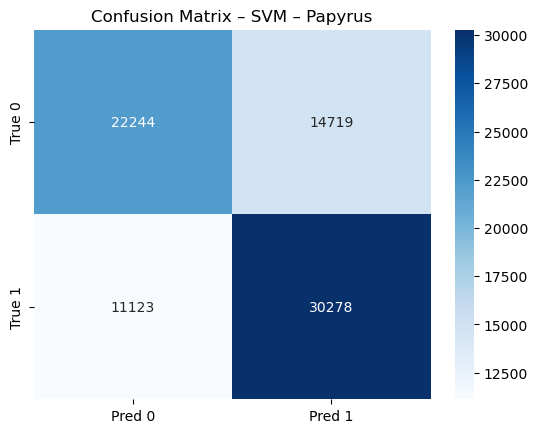

In [25]:
cm = confusion_matrix(true_labels, binary_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix – SVM – Papyrus")
plt.show()

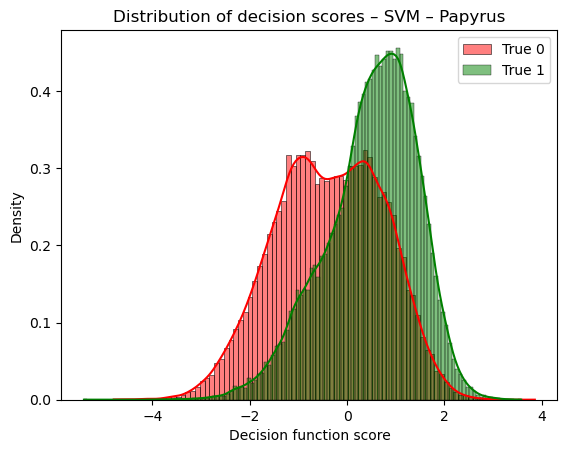

In [26]:
plt.figure()
sns.histplot(decision_scores[true_labels==0], color="red", label="True 0", kde=True, stat="density")
sns.histplot(decision_scores[true_labels==1], color="green", label="True 1", kde=True, stat="density")
plt.xlabel("Decision function score")
plt.ylabel("Density")
plt.title("Distribution of decision scores – SVM – Papyrus")
plt.legend()
plt.show()

# PAPYRUS + TB

### XGB

In [28]:
xgb_model = XGBClassifier()
xgb_model.load_model("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/xxl_stash/Papyrus_tb_barlowdti_xxl_model_tb_pap.json")

# === Previsões e Avaliação para GBM ===
print("\n===== Avaliação - XGBoost =====")
gbm_preds = xgb_model.predict_proba(test_vectors)[:, 1]
gbm_binary = (gbm_preds >= 0.5).astype(int)

roc = roc_auc_score(true_labels, gbm_preds)
acc = accuracy_score(true_labels, gbm_binary)
prec = precision_score(true_labels, gbm_binary)
rec = recall_score(true_labels, gbm_binary)
f1 = f1_score(true_labels, gbm_binary)
mcc = matthews_corrcoef(true_labels, gbm_binary)
pr_auc = average_precision_score(true_labels, gbm_preds)
cm = confusion_matrix(true_labels, gbm_binary)

print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ACCURACY: {acc:.4f}")
print(f"PRECISION: {prec:.4f}")
print(f"RECALL: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")


===== Avaliação - XGBoost =====
ROC-AUC: 0.8720
PR-AUC: 0.8752
ACCURACY: 0.7867
PRECISION: 0.7909
RECALL: 0.8038
F1-Score: 0.7973
MCC: 0.5723


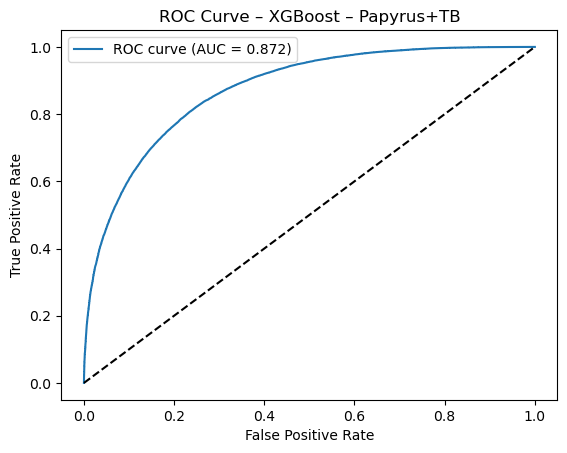

In [29]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_labels, gbm_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost – Papyrus+TB")
plt.legend()
plt.show()

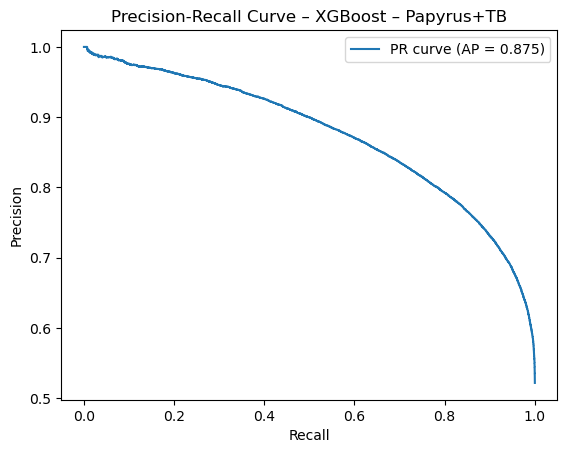

In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(true_labels, gbm_preds)
ap = average_precision_score(true_labels, gbm_preds)

plt.figure()
plt.plot(rec, prec, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – XGBoost – Papyrus+TB")
plt.legend()
plt.show()

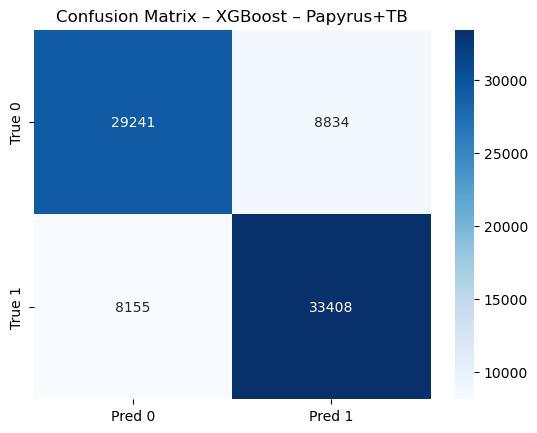

In [31]:
cm = confusion_matrix(true_labels, gbm_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix – XGBoost – Papyrus+TB")
plt.show()

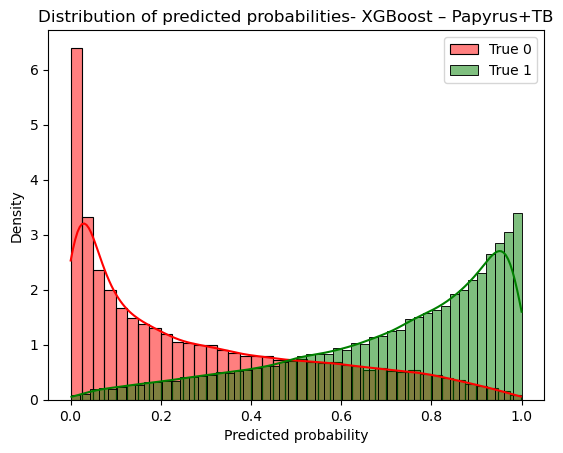

In [32]:
plt.figure()
sns.histplot(gbm_preds[true_labels==0], color="red", label="True 0", kde=True, stat="density")
sns.histplot(gbm_preds[true_labels==1], color="green", label="True 1", kde=True, stat="density")
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.title("Distribution of predicted probabilities- XGBoost – Papyrus+TB")
plt.legend()
plt.show()

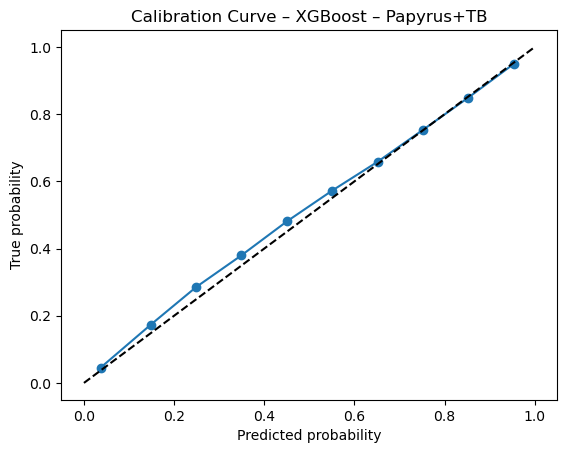

In [33]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(true_labels, gbm_preds, n_bins=10)

plt.figure()
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Calibration Curve – XGBoost – Papyrus+TB")
plt.show()

### SVM

ROC-AUC: 0.7355
PR-AUC: 0.7211
ACCURACY: 0.6805
PRECISION: 0.6749
RECALL: 0.7482
F1-Score: 0.7097
MCC: 0.3589


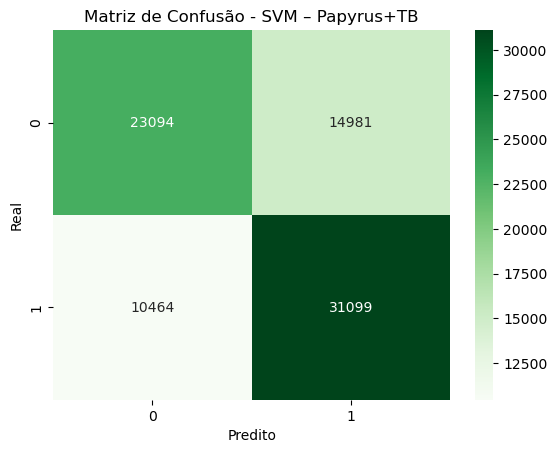

In [34]:
import joblib
from sklearn.metrics import *

# Carregar modelo e scaler
svm = joblib.load("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/xxl_stash/Papyrus_tb_barlowdti_xxl_model_svm_tb_pap.pkl") 
scaler = joblib.load("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/xxl_stash/Papyrus_tb_barlowdti_xxl_svm_scaler_tb_pap.pkl") #

test_bt_scaled = scaler.transform(test_vectors)

# Como não há predict_proba com hinge, usas decision_function
decision_scores = svm.decision_function(test_bt_scaled)
binary_preds = (decision_scores >= 0).astype(int)

roc = roc_auc_score(true_labels, decision_scores)
acc = accuracy_score(true_labels, binary_preds)
prec = precision_score(true_labels, binary_preds)
rec = recall_score(true_labels, binary_preds)
f1 = f1_score(true_labels, binary_preds)
mcc = matthews_corrcoef(true_labels, binary_preds)
pr_auc = average_precision_score(true_labels, decision_scores)
cm = confusion_matrix(true_labels, binary_preds)

print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ACCURACY: {acc:.4f}")
print(f"PRECISION: {prec:.4f}")
print(f"RECALL: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusão - SVM – Papyrus+TB")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

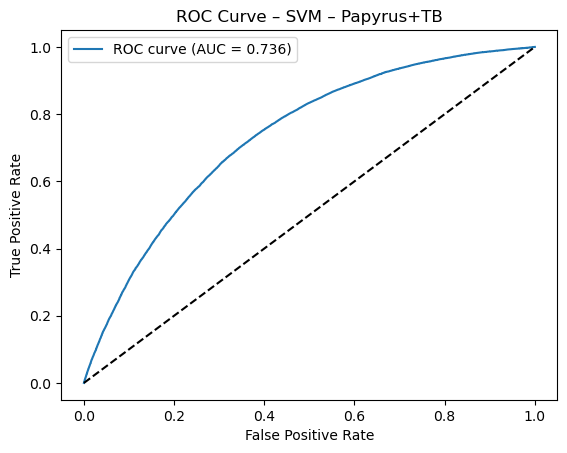

In [35]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_labels, decision_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – SVM – Papyrus+TB")
plt.legend()
plt.show()

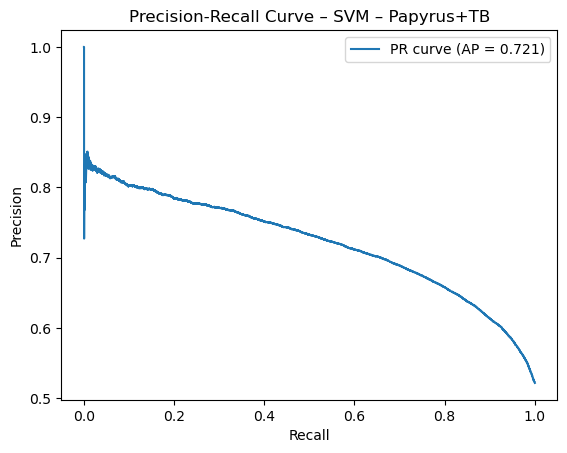

In [36]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(true_labels, decision_scores)
ap = average_precision_score(true_labels, decision_scores)

plt.figure()
plt.plot(rec, prec, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – SVM – Papyrus+TB")
plt.legend()
plt.show()

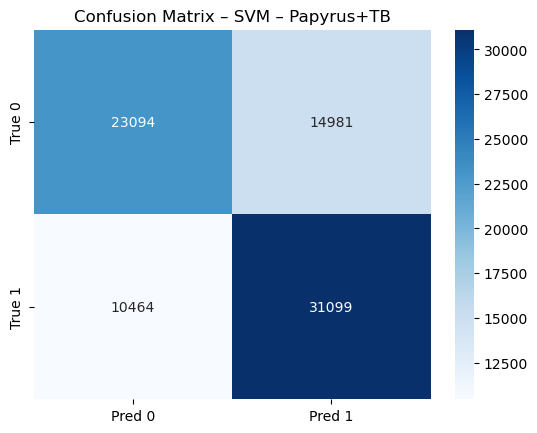

In [37]:
cm = confusion_matrix(true_labels, binary_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix – SVM – Papyrus+TB")
plt.show()

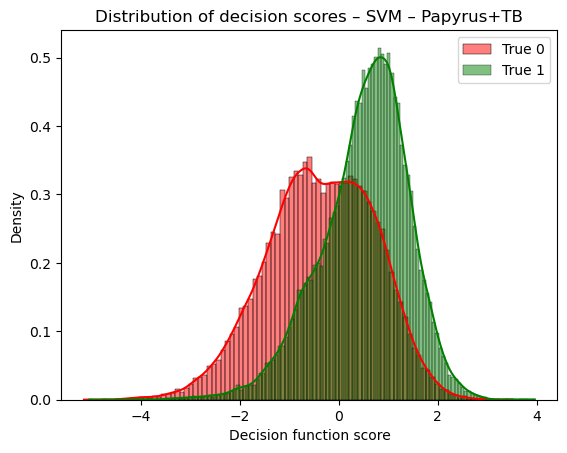

In [38]:
plt.figure()
sns.histplot(decision_scores[true_labels==0], color="red", label="True 0", kde=True, stat="density")
sns.histplot(decision_scores[true_labels==1], color="green", label="True 1", kde=True, stat="density")
plt.xlabel("Decision function score")
plt.ylabel("Density")
plt.title("Distribution of decision scores – SVM – Papyrus+TB")
plt.legend()
plt.show()

## TB

### xgb

In [40]:
xgb_model = XGBClassifier()
xgb_model.load_model("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/xxl_stash/Tb_barlowdti_xxl_model_tb.json")

# === Previsões e Avaliação para GBM ===
print("\n===== Avaliação - XGBoost =====")
gbm_preds = xgb_model.predict_proba(test_vectors)[:, 1]
gbm_binary = (gbm_preds >= 0.5).astype(int)

roc = roc_auc_score(true_labels, gbm_preds)
acc = accuracy_score(true_labels, gbm_binary)
prec = precision_score(true_labels, gbm_binary)
rec = recall_score(true_labels, gbm_binary)
f1 = f1_score(true_labels, gbm_binary)
mcc = matthews_corrcoef(true_labels, gbm_binary)
pr_auc = average_precision_score(true_labels, gbm_preds)
cm = confusion_matrix(true_labels, gbm_binary)

print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ACCURACY: {acc:.4f}")
print(f"PRECISION: {prec:.4f}")
print(f"RECALL: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")


===== Avaliação - XGBoost =====
ROC-AUC: 0.8642
PR-AUC: 0.4995
ACCURACY: 0.8893
PRECISION: 0.6329
RECALL: 0.3086
F1-Score: 0.4149
MCC: 0.3903


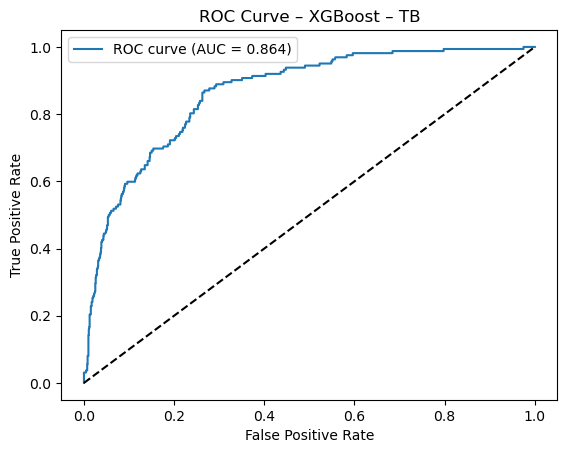

In [41]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_labels, gbm_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost – TB")
plt.legend()
plt.show()

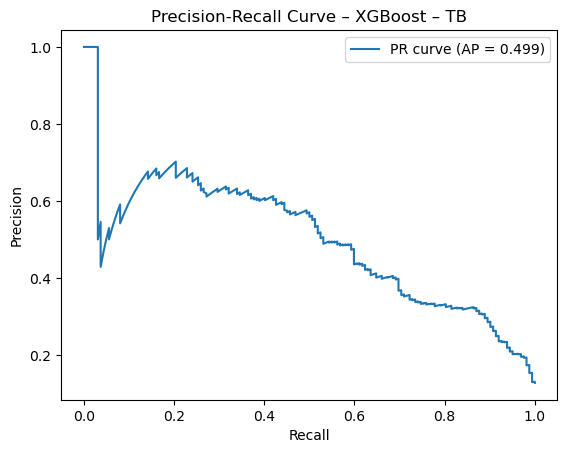

In [42]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(true_labels, gbm_preds)
ap = average_precision_score(true_labels, gbm_preds)

plt.figure()
plt.plot(rec, prec, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – XGBoost – TB")
plt.legend()
plt.show()

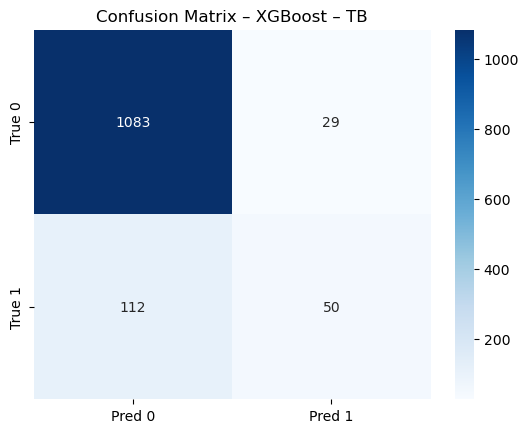

In [43]:
cm = confusion_matrix(true_labels, gbm_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix – XGBoost – TB")
plt.show()

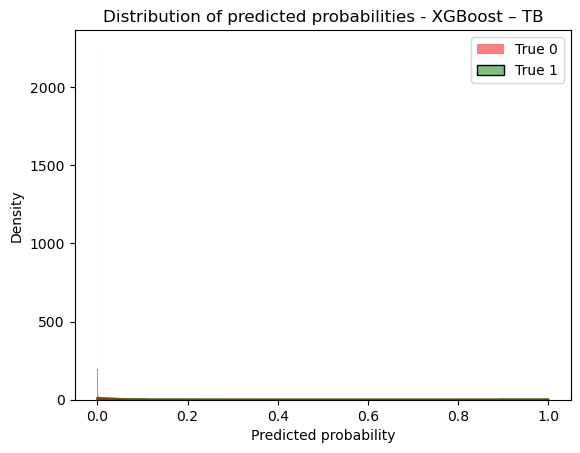

In [44]:
plt.figure()
sns.histplot(gbm_preds[true_labels==0], color="red", label="True 0", kde=True, stat="density")
sns.histplot(gbm_preds[true_labels==1], color="green", label="True 1", kde=True, stat="density")
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.title("Distribution of predicted probabilities - XGBoost – TB")
plt.legend()
plt.show()

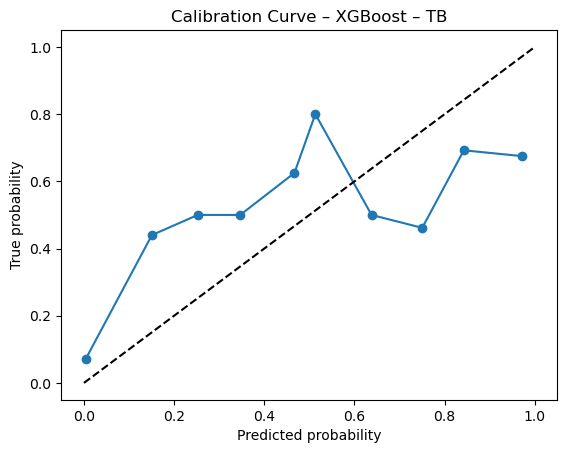

In [45]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(true_labels, gbm_preds, n_bins=10)

plt.figure()
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Calibration Curve – XGBoost – TB")
plt.show()

### SVM

ROC-AUC: 0.7960
PR-AUC: 0.3406
ACCURACY: 0.8548
PRECISION: 0.4109
RECALL: 0.3272
F1-Score: 0.3643
MCC: 0.2858


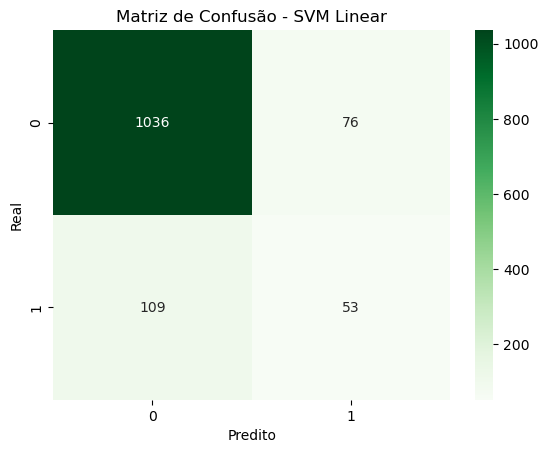

In [46]:
import joblib
from sklearn.metrics import *

# Carregar modelo e scaler
svm = joblib.load("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/xxl_stash/Tb_barlowdti_xxl_model_svm_tb.pkl") 
scaler = joblib.load("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/xxl_stash/Tb_barlowdti_xxl_svm_scaler_tb.pkl") #

test_bt_scaled = scaler.transform(test_vectors)

# Como não há predict_proba com hinge, usas decision_function
decision_scores = svm.decision_function(test_bt_scaled)
binary_preds = (decision_scores >= 0).astype(int)

roc = roc_auc_score(true_labels, decision_scores)
acc = accuracy_score(true_labels, binary_preds)
prec = precision_score(true_labels, binary_preds)
rec = recall_score(true_labels, binary_preds)
f1 = f1_score(true_labels, binary_preds)
mcc = matthews_corrcoef(true_labels, binary_preds)
pr_auc = average_precision_score(true_labels, decision_scores)
cm = confusion_matrix(true_labels, binary_preds)

print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ACCURACY: {acc:.4f}")
print(f"PRECISION: {prec:.4f}")
print(f"RECALL: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusão - SVM Linear")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

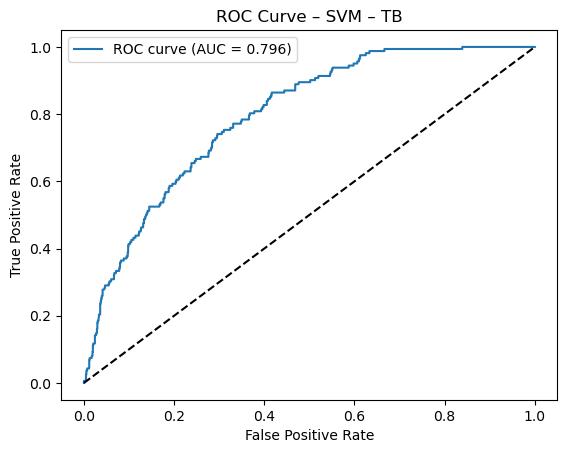

In [47]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_labels, decision_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – SVM – TB")
plt.legend()
plt.show()

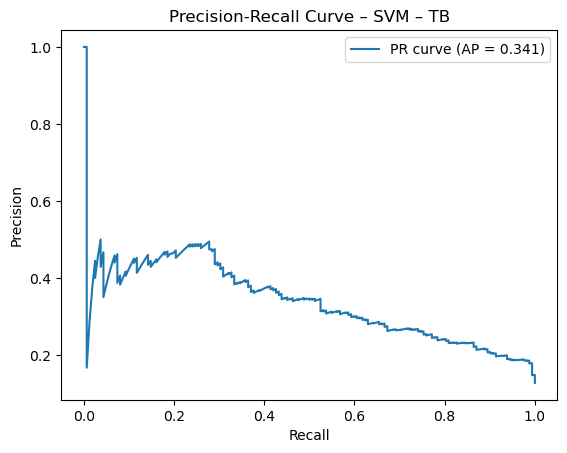

In [48]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(true_labels, decision_scores)
ap = average_precision_score(true_labels, decision_scores)

plt.figure()
plt.plot(rec, prec, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – SVM – TB")
plt.legend()
plt.show()

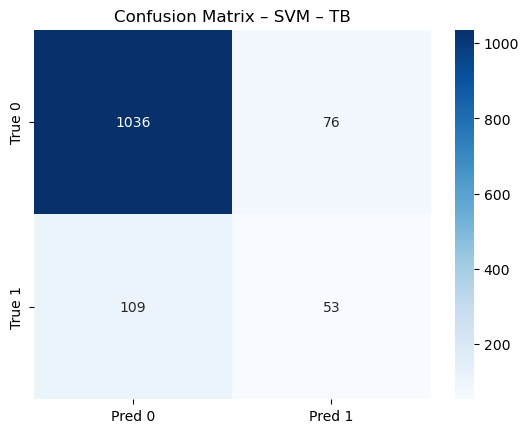

In [49]:
cm = confusion_matrix(true_labels, binary_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix – SVM – TB")
plt.show()

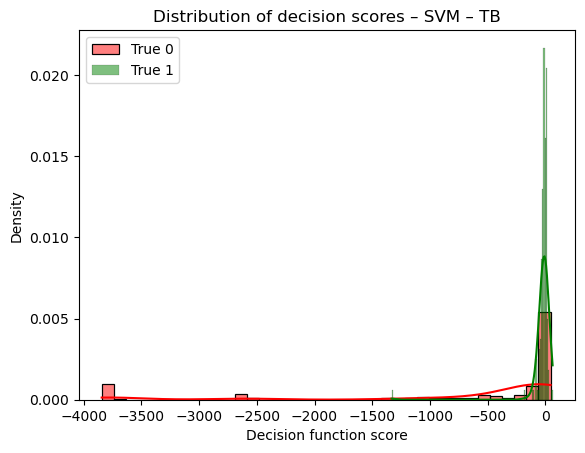

In [50]:
plt.figure()
sns.histplot(decision_scores[true_labels==0], color="red", label="True 0", kde=True, stat="density")
sns.histplot(decision_scores[true_labels==1], color="green", label="True 1", kde=True, stat="density")
plt.xlabel("Decision function score")
plt.ylabel("Density")
plt.title("Distribution of decision scores – SVM – TB")
plt.legend()
plt.show()

## Metricas tb no pap+tb

In [52]:
xgb_model = XGBClassifier()
xgb_model.load_model("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/xxl_stash/Papyrus_tb_barlowdti_xxl_model_tb_pap.json")

# === Previsões e Avaliação para GBM ===
print("\n===== Avaliação - XGBoost =====")
gbm_preds = xgb_model.predict_proba(test_vectors)[:, 1]
gbm_binary = (gbm_preds >= 0.5).astype(int)

roc = roc_auc_score(true_labels, gbm_preds)
acc = accuracy_score(true_labels, gbm_binary)
prec = precision_score(true_labels, gbm_binary)
rec = recall_score(true_labels, gbm_binary)
f1 = f1_score(true_labels, gbm_binary)
mcc = matthews_corrcoef(true_labels, gbm_binary)
pr_auc = average_precision_score(true_labels, gbm_preds)
cm = confusion_matrix(true_labels, gbm_binary)

print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ACCURACY: {acc:.4f}")
print(f"PRECISION: {prec:.4f}")
print(f"RECALL: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")


===== Avaliação - XGBoost =====
ROC-AUC: 0.8302
PR-AUC: 0.4255
ACCURACY: 0.8654
PRECISION: 0.4458
RECALL: 0.2270
F1-Score: 0.3008
MCC: 0.2514


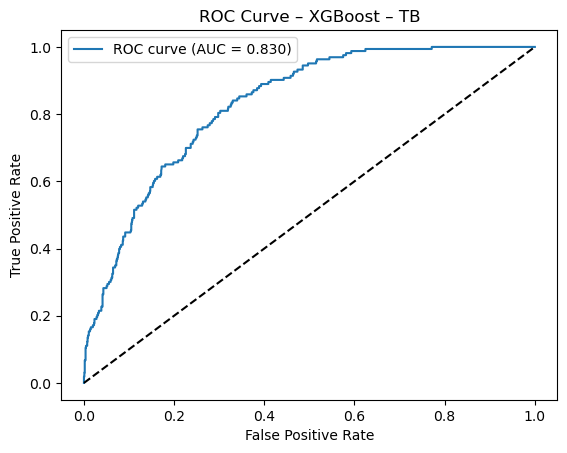

In [53]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_labels, gbm_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost – TB")
plt.legend()
plt.show()

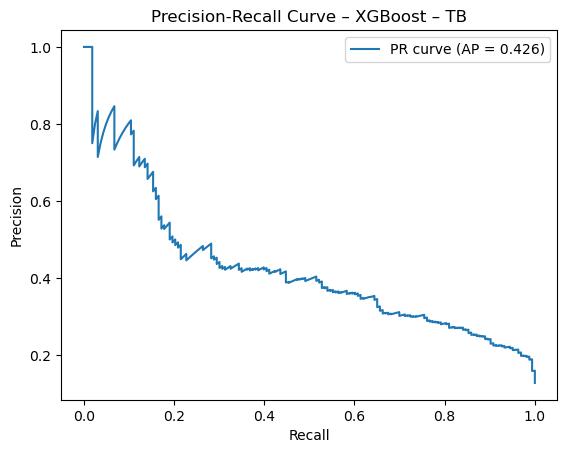

In [54]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(true_labels, gbm_preds)
ap = average_precision_score(true_labels, gbm_preds)

plt.figure()
plt.plot(rec, prec, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – XGBoost – TB")
plt.legend()
plt.show()

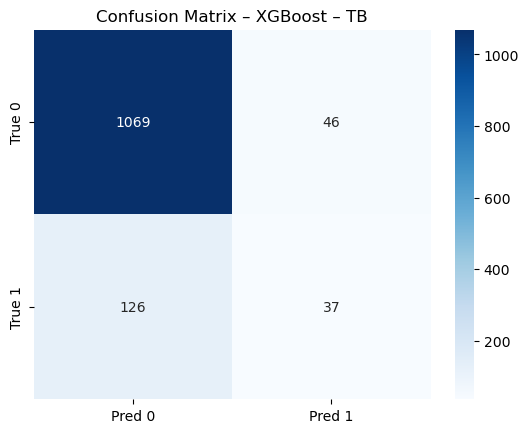

In [55]:
cm = confusion_matrix(true_labels, gbm_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix – XGBoost – TB")
plt.show()

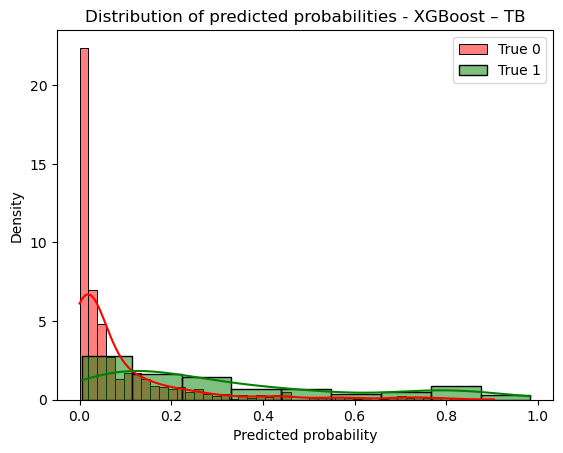

In [56]:
plt.figure()
sns.histplot(gbm_preds[true_labels==0], color="red", label="True 0", kde=True, stat="density")
sns.histplot(gbm_preds[true_labels==1], color="green", label="True 1", kde=True, stat="density")
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.title("Distribution of predicted probabilities - XGBoost – TB")
plt.legend()
plt.show()

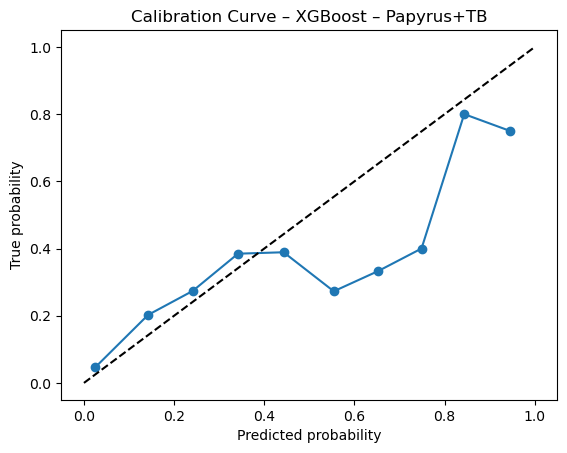

In [57]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(true_labels, gbm_preds, n_bins=10)

plt.figure()
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Calibration Curve – XGBoost – Papyrus+TB")
plt.show()

### SVM

ROC-AUC: 0.6340
PR-AUC: 0.2147
ACCURACY: 0.8592
PRECISION: 0.3023
RECALL: 0.0798
F1-Score: 0.1262
MCC: 0.0978


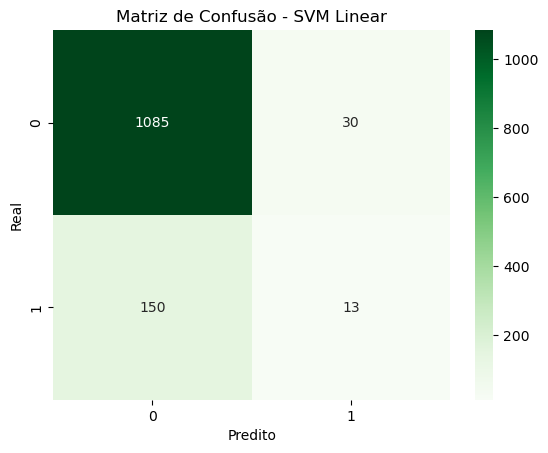

In [58]:
import joblib
from sklearn.metrics import *

# Carregar modelo e scaler
svm = joblib.load("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/xxl_stash/Papyrus_tb_barlowdti_xxl_model_svm_tb_pap.pkl") 
scaler = joblib.load("/home/resperanca/Tuberculosis_Tese/Source/Models/BarlowDTI/model/xxl_stash/Papyrus_tb_barlowdti_xxl_svm_scaler_tb_pap.pkl") #

test_bt_scaled = scaler.transform(test_vectors)

# Como não há predict_proba com hinge, usas decision_function
decision_scores = svm.decision_function(test_bt_scaled)
binary_preds = (decision_scores >= 0).astype(int)

roc = roc_auc_score(true_labels, decision_scores)
acc = accuracy_score(true_labels, binary_preds)
prec = precision_score(true_labels, binary_preds)
rec = recall_score(true_labels, binary_preds)
f1 = f1_score(true_labels, binary_preds)
mcc = matthews_corrcoef(true_labels, binary_preds)
pr_auc = average_precision_score(true_labels, decision_scores)
cm = confusion_matrix(true_labels, binary_preds)

print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ACCURACY: {acc:.4f}")
print(f"PRECISION: {prec:.4f}")
print(f"RECALL: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusão - SVM Linear")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

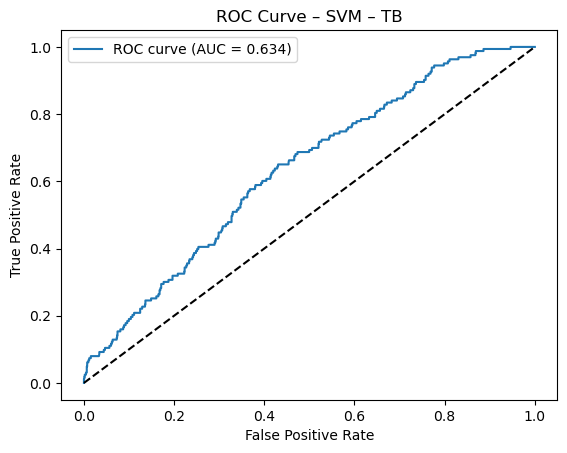

In [59]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_labels, decision_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – SVM – TB")
plt.legend()
plt.show()

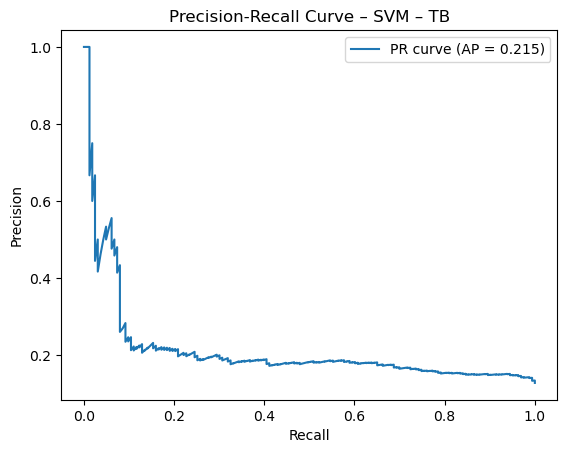

In [60]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(true_labels, decision_scores)
ap = average_precision_score(true_labels, decision_scores)

plt.figure()
plt.plot(rec, prec, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – SVM – TB")
plt.legend()
plt.show()

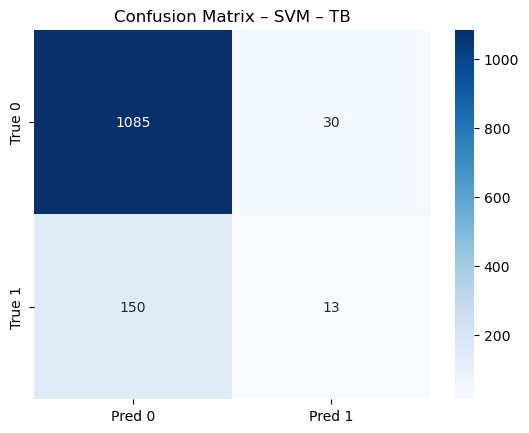

In [61]:
cm = confusion_matrix(true_labels, binary_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix – SVM – TB")
plt.show()

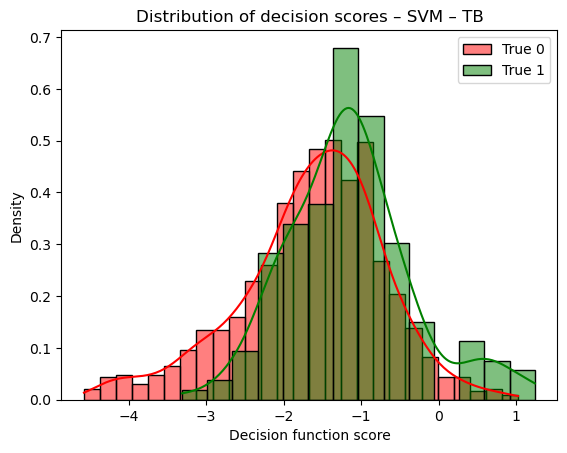

In [62]:
plt.figure()
sns.histplot(decision_scores[true_labels==0], color="red", label="True 0", kde=True, stat="density")
sns.histplot(decision_scores[true_labels==1], color="green", label="True 1", kde=True, stat="density")
plt.xlabel("Decision function score")
plt.ylabel("Density")
plt.title("Distribution of decision scores – SVM – TB")
plt.legend()
plt.show()